# Playground Series S6E1: Predicting Student Test Scores

**Challenge**: Predict student test scores using available features
**Metric**: Root Mean Squared Error (RMSE)
**Goal**: Build a baseline model and improve iteratively

---

## Workflow
1. Load and explore data (EDA)
2. Establish baseline model
3. Feature engineering & preprocessing
4. Model selection and tuning
5. Ensemble and final optimization

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Check if running on Kaggle
IS_KAGGLE = 'KAGGLE_DATA_PROXY_URL' in os.environ
print(f"Running on Kaggle: {IS_KAGGLE}")

# Detect environment paths
if IS_KAGGLE:
    DATA_PATH = Path('/kaggle/input/playground-series-s6e1/')
    OUTPUT_PATH = Path('/kaggle/working')
else:
    # Notebook lives in notebooks
    DATA_PATH = Path('data')
    OUTPUT_PATH = Path('submissions')

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Running on Kaggle: False
Data path: data
Output path: submissions


In [4]:
# Load data
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')
submission_sample = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

print("Data Loaded Successfully!")
print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {submission_sample.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print(f"Submission columns: {submission_sample.columns.tolist()}")

Data Loaded Successfully!

Train shape: (630000, 13)
Test shape: (270000, 12)
Sample submission shape: (270000, 2)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']
Test columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Submission columns: ['id', 'exam_score']


## 1. Exploratory Data Analysis (EDA)

In [5]:
# Display basic info
print("=" * 60)
print("TRAINING DATA INFO")
print("=" * 60)
print(f"\nShape: {train_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head())
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:")
print(train_df.isnull().sum())
print(f"\nBasic statistics:")
print(train_df.describe())

TRAINING DATA INFO

Shape: (630000, 13)

First few rows:
   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   



TARGET VARIABLE ANALYSIS

Duplicate rows: 0

Target variable (exam_score) statistics:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


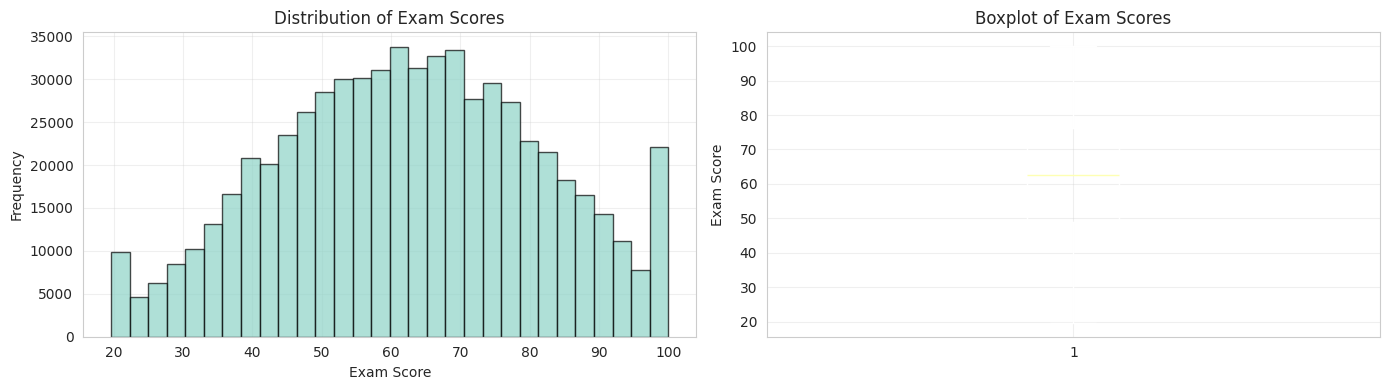

In [26]:
# Check for duplicates and analyze target variable
print("\n" + "=" * 60)
print("TARGET VARIABLE ANALYSIS")
print("=" * 60)
print(f"\nDuplicate rows: {train_df.duplicated().sum()}")
print(f"\nTarget variable (exam_score) statistics:")
print(train_df['exam_score'].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_df['exam_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].grid(alpha=0.3)

axes[1].boxplot(train_df['exam_score'])
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Boxplot of Exam Scores')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE ANALYSIS

Numeric features (4): ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

CORRELATION WITH TARGET (exam_score)
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


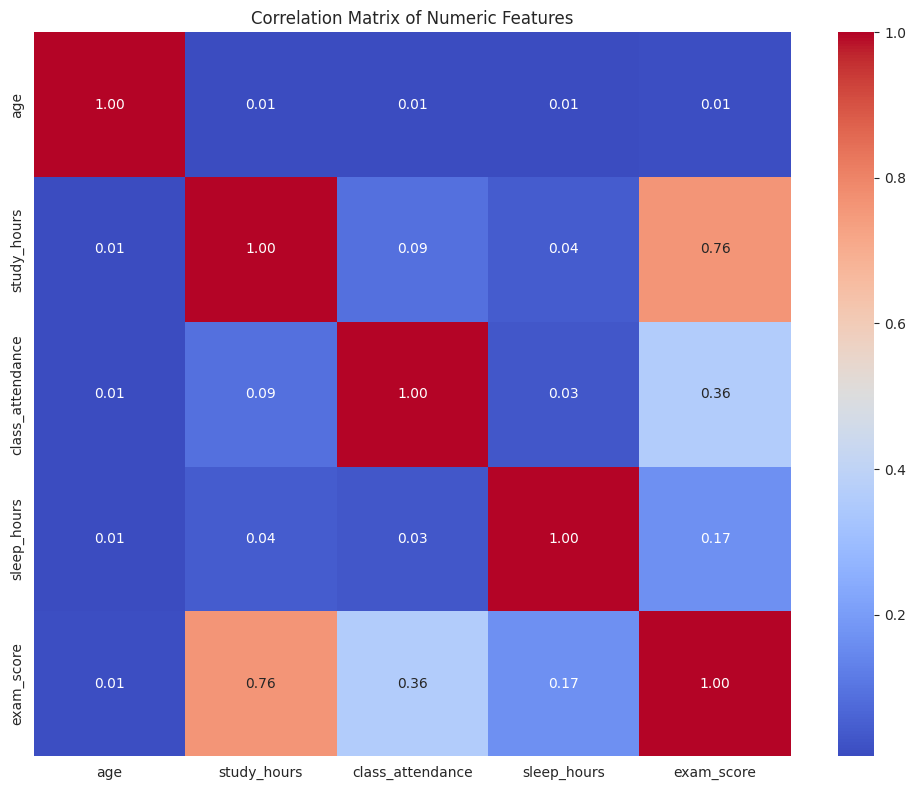

In [8]:
# Analyze features by type
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target and ID from feature list
numeric_features = [col for col in numeric_features if col not in ['exam_score', 'id']]
categorical_features = [col for col in categorical_features if col != 'id']

print("\n" + "=" * 60)
print("FEATURE ANALYSIS")
print("=" * 60)
print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Correlation with target
print("\n" + "=" * 60)
print("CORRELATION WITH TARGET (exam_score)")
print("=" * 60)
correlations = train_df[numeric_features + ['exam_score']].corr()['exam_score'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[numeric_features + ['exam_score']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [9]:
# Prepare data for modeling
def preprocess_data(df, categorical_features=None, numeric_features=None, fit_scalers=False, scalers=None):
    """
    Preprocess data: encode categorical variables and scale numeric features
    """
    df_processed = df.copy()
    
    # Encode categorical variables
    if categorical_features:
        le_dict = scalers.get('label_encoders', {}) if scalers else {}
        
        for col in categorical_features:
            if col in df_processed.columns:
                if fit_scalers:
                    le = LabelEncoder()
                    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
                    le_dict[col] = le
                else:
                    if col in le_dict:
                        df_processed[col] = le_dict[col].transform(df_processed[col].astype(str))
    
    # Scale numeric features
    if numeric_features:
        scaler = scalers.get('scaler') if scalers else None
        
        if fit_scalers:
            scaler = StandardScaler()
            df_processed[numeric_features] = scaler.fit_transform(df_processed[numeric_features])
        else:
            if scaler:
                df_processed[numeric_features] = scaler.transform(df_processed[numeric_features])
    
    return df_processed, {'scaler': scaler, 'label_encoders': le_dict} if fit_scalers else None

# Prepare training data
train_processed, scalers = preprocess_data(
    train_df,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    fit_scalers=True
)

# Prepare test data
test_processed, _ = preprocess_data(
    test_df,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    fit_scalers=False,
    scalers=scalers
)

print("Data preprocessing completed!")
print(f"\nProcessed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")

Data preprocessing completed!

Processed training data shape: (630000, 13)
Processed test data shape: (270000, 12)


## 3. Baseline Model

In [10]:
# Split data for baseline
X = train_processed[numeric_features + categorical_features]
y = train_processed['exam_score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Train baseline Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

# Evaluate baseline
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\n" + "=" * 60)
print("BASELINE MODEL PERFORMANCE (Linear Regression)")
print("=" * 60)
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Training set: (504000, 11)
Validation set: (126000, 11)

BASELINE MODEL PERFORMANCE (Linear Regression)
Training RMSE: 9.9596
Validation RMSE: 9.9452
Training R²: 0.7232
Validation R²: 0.7219


## 4. Model Improvements (CV & Better Models)
We will compare tree-based models with cross-validation and pick the best one for submission.

In [11]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cross_validate_model(model_builder, X, y, use_cat_features=False, cat_features=None, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = model_builder()
        if use_cat_features and cat_features:
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        else:
            model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmses.append(rmse(y_val, preds))
    return float(np.mean(rmses)), float(np.std(rmses))

# Data for models
X_lgb = train_processed[numeric_features + categorical_features]
y_full = train_processed['exam_score']
X_test_lgb = test_processed[numeric_features + categorical_features]

# CatBoost works directly on raw data with categorical features
X_cb = train_df.drop(columns=['exam_score'])
test_cb = test_df.copy()
cat_feature_indices = [X_cb.columns.get_loc(col) for col in categorical_features]

# Define model builders
def build_lgbm():
    return LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        reg_alpha=0.1,
        reg_lambda=0.3
    )

def build_xgb():
    return XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        reg_alpha=0.1,
        reg_lambda=0.3,
        tree_method='hist'
    )

def build_cat():
    return CatBoostRegressor(
        iterations=400,
        learning_rate=0.08,
        depth=8,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        verbose=False,
        l2_leaf_reg=3
    )

# Cross-validate models
results = []

lgb_mean, lgb_std = cross_validate_model(build_lgbm, X_lgb, y_full)
results.append({'model': 'LightGBM', 'mean_rmse': lgb_mean, 'std_rmse': lgb_std})

xgb_mean, xgb_std = cross_validate_model(build_xgb, X_lgb, y_full)
results.append({'model': 'XGBoost', 'mean_rmse': xgb_mean, 'std_rmse': xgb_std})

cat_mean, cat_std = cross_validate_model(build_cat, X_cb, y_full, use_cat_features=True, cat_features=cat_feature_indices)
results.append({'model': 'CatBoost', 'mean_rmse': cat_mean, 'std_rmse': cat_std})

# Show results sorted by mean RMSE
results_sorted = sorted(results, key=lambda x: x['mean_rmse'])
print("Model CV Results (RMSE, lower is better):")
for res in results_sorted:
    print(f"- {res['model']}: {res['mean_rmse']:.4f} ± {res['std_rmse']:.4f}")

best_model_name = results_sorted[0]['model']
print(f"\nBest model based on CV: {best_model_name}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 11
[LightGBM] [Info] Start training from score 62.482335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 11
[LightGBM] [Info] Start training from score 62.502155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [15]:
# Quick view of CV results without recomputing
try:
    print("Model CV Results (RMSE, lower is better):")
    for res in results_sorted:
        print(f"- {res['model']}: {res['mean_rmse']:.4f} ± {res['std_rmse']:.4f}")
    print(f"\nBest model based on CV: {best_model_name}")
except Exception as e:
    print("Run the CV cell above to populate results. Error:", e)

Model CV Results (RMSE, lower is better):
- XGBoost: 8.7713 ± 0.0128
- LightGBM: 8.7720 ± 0.0120
- CatBoost: 8.7916 ± 0.0120

Best model based on CV: XGBoost


## 5. Feature Importance Analysis & Selection
Train tree models to identify feature importance, then experiment with feature sets.

Feature Importance (top to bottom):
  study_hours: 0.5295
  sleep_quality: 0.1268
  study_method: 0.1021
  class_attendance: 0.1015
  facility_rating: 0.0993
  sleep_hours: 0.0359
  age: 0.0013
  gender: 0.0012
  course: 0.0010
  exam_difficulty: 0.0008
  internet_access: 0.0007


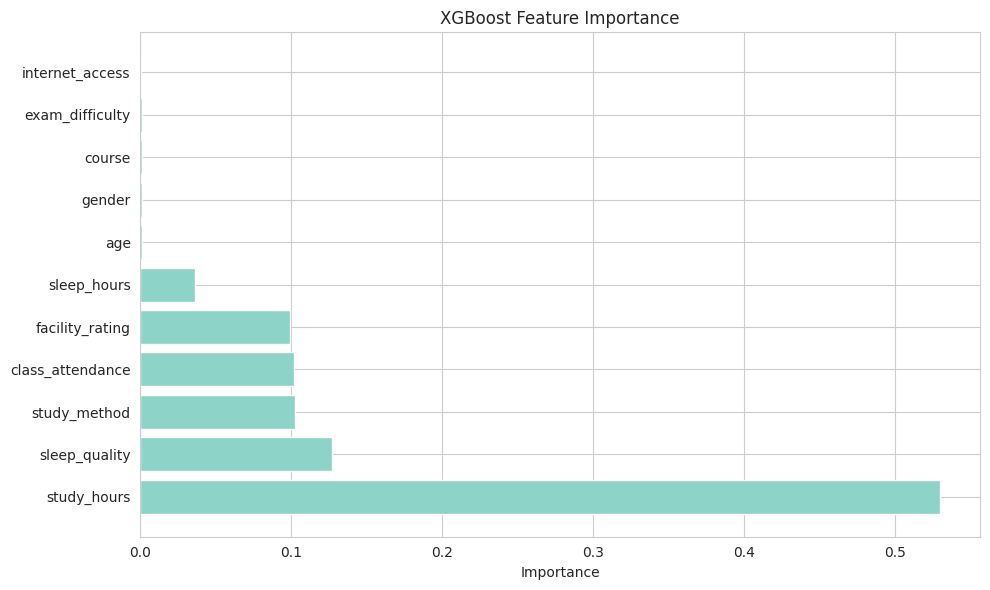

In [12]:
# Train quick XGBoost to get feature importance
xgb_import = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_import.fit(X_lgb, y_full)

# Extract feature importance
feat_import_dict = dict(zip(numeric_features + categorical_features, xgb_import.feature_importances_))
feat_import_sorted = sorted(feat_import_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Importance (top to bottom):")
for feat, imp in feat_import_sorted:
    print(f"  {feat}: {imp:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
feats = [f[0] for f in feat_import_sorted]
imps = [f[1] for f in feat_import_sorted]
plt.barh(feats, imps)
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [13]:
# Test feature sets: all features vs. low-importance features dropped
weak_features = [feat for feat, imp in feat_import_sorted if imp < 0.01]  # Drop features with <0.01 importance
strong_features = [feat for feat, imp in feat_import_sorted if imp >= 0.01]

print(f"\nFeature Set Analysis:")
print(f"  Total features: {len(numeric_features + categorical_features)}")
print(f"  Weak features (importance < 0.01): {weak_features}")
print(f"  Strong features: {len(strong_features)}")

# Prepare feature sets
X_strong = X_lgb[strong_features].copy()
X_test_strong = X_test_lgb[strong_features].copy()

# CV comparison: all features vs. strong features only
def cross_validate_feature_set(model_builder, X, y, X_test, test_preds_base=None, set_name="", folds=3):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = model_builder()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmses.append(rmse(y_val, preds))
    cv_mean = np.mean(rmses)
    cv_std = np.std(rmses)
    return cv_mean, cv_std

# Compare on feature sets
print("\n" + "=" * 60)
print("FEATURE SET COMPARISON (3-fold CV)")
print("=" * 60)

# All features with tuned XGBoost
xgb_all_mean, xgb_all_std = cross_validate_feature_set(
    lambda: XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6, 
        subsample=0.85, colsample_bytree=0.8, reg_alpha=0.15, reg_lambda=0.4, random_state=42
    ),
    X_lgb, y_full, X_test_lgb,
    set_name="XGBoost (All Features, Tuned)"
)
print(f"XGBoost (All Features, Tuned):     {xgb_all_mean:.4f} ± {xgb_all_std:.4f}")

# Strong features only
xgb_strong_mean, xgb_strong_std = cross_validate_feature_set(
    lambda: XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6, 
        subsample=0.85, colsample_bytree=0.8, reg_alpha=0.15, reg_lambda=0.4, random_state=42
    ),
    X_strong, y_full, X_test_strong,
    set_name="XGBoost (Strong Features)"
)
print(f"XGBoost (Strong Features):         {xgb_strong_mean:.4f} ± {xgb_strong_std:.4f}")

# LightGBM all features tuned
lgb_all_mean, lgb_all_std = cross_validate_feature_set(
    lambda: LGBMRegressor(
        n_estimators=400, learning_rate=0.08, num_leaves=100, max_depth=10,
        subsample=0.85, colsample_bytree=0.8, reg_alpha=0.15, reg_lambda=0.4, random_state=42
    ),
    X_lgb, y_full, X_test_lgb,
    set_name="LightGBM (All Features, Tuned)"
)
print(f"LightGBM (All Features, Tuned):   {lgb_all_mean:.4f} ± {lgb_all_std:.4f}")

# Decide best config
configs = [
    ("XGBoost All", xgb_all_mean, "xgb", "all"),
    ("XGBoost Strong", xgb_strong_mean, "xgb", "strong"),
    ("LightGBM All", lgb_all_mean, "lgb", "all"),
]
best_config = min(configs, key=lambda x: x[1])
print(f"\nBest config: {best_config[0]} with RMSE {best_config[1]:.4f}")
best_model_type = best_config[2]
best_feature_set = best_config[3]


Feature Set Analysis:
  Total features: 11
  Weak features (importance < 0.01): ['age', 'gender', 'course', 'exam_difficulty', 'internet_access']
  Strong features: 6

FEATURE SET COMPARISON (3-fold CV)
XGBoost (All Features, Tuned):     8.7791 ± 0.0107
XGBoost (Strong Features):         8.7781 ± 0.0110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 420000, number of used features: 11
[LightGBM] [Info] Start training from score 62.475898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of 

In [14]:
# Train final best model and save optimized submission
print("\n" + "=" * 60)
print("TRAINING FINAL OPTIMIZED MODEL")
print("=" * 60)

if best_feature_set == "all":
    X_final = X_lgb
    X_test_final = X_test_lgb
else:
    X_final = X_strong
    X_test_final = X_test_strong

if best_model_type == "xgb":
    final_model = XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6, 
        subsample=0.85, colsample_bytree=0.8, reg_alpha=0.15, reg_lambda=0.4, random_state=42
    )
else:  # lgb
    final_model = LGBMRegressor(
        n_estimators=400, learning_rate=0.08, num_leaves=100, max_depth=10,
        subsample=0.85, colsample_bytree=0.8, reg_alpha=0.15, reg_lambda=0.4, random_state=42
    )

final_model.fit(X_final, y_full)
final_preds = final_model.predict(X_test_final)

# Save optimized submission
submission_final = submission_sample.copy()
submission_final['exam_score'] = final_preds
submission_final.to_csv(f'{OUTPUT_PATH}/submission.csv', index=False)

print(f"\nOptimized model: {best_model_type.upper()} with {best_feature_set} features")
print(f"Submission saved to {OUTPUT_PATH}/submission.csv")
print(submission_final.head())

print(f"\nExpected CV RMSE improvement: {best_config[1]:.4f} (vs. baseline {val_rmse:.4f})")


TRAINING FINAL OPTIMIZED MODEL
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 11
[LightGBM] [Info] Start training from score 62.506672

Optimized model: LGB with all features
Submission saved to submissions/submission.csv
       id  exam_score
0  630000   71.838364
1  630001   70.710925
2  630002   87.181331
3  630003   55.109356
4  630004   48.007015

Expected CV RMSE improvement: 8.7713 (vs. baseline 9.9452)


In [16]:
print("\n" + "=" * 60)
print("SUMMARY: FEATURE IMPORTANCE & OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\nTop 5 Most Important Features:")
for feat, imp in feat_import_sorted[:5]:
    print(f"  {feat}: {imp:.4f}")
print(f"\nLow-importance features dropped: {weak_features}")
print(f"\nBest Configuration: {best_model_type.upper()} with {best_feature_set} features")
print(f"Expected CV RMSE: {best_config[1]:.4f}")
print(f"Baseline RMSE: {val_rmse:.4f}")
print(f"Improvement: {val_rmse - best_config[1]:.4f} ({100*(val_rmse - best_config[1])/val_rmse:.2f}%)")


SUMMARY: FEATURE IMPORTANCE & OPTIMIZATION RESULTS

Top 5 Most Important Features:
  study_hours: 0.5295
  sleep_quality: 0.1268
  study_method: 0.1021
  class_attendance: 0.1015
  facility_rating: 0.0993

Low-importance features dropped: ['age', 'gender', 'course', 'exam_difficulty', 'internet_access']

Best Configuration: LGB with all features
Expected CV RMSE: 8.7713
Baseline RMSE: 9.9452
Improvement: 1.1739 (11.80%)
